In [57]:
#!pip install -q tensorflow-recommenders
#!pip install -q --upgrade tensorflow-datasets
#!pip install -q scann

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
from typing import Dict, Text
import random
from collections import Counter

In [2]:
tfrs.__version__, tf.__version__

('v0.7.0', '2.9.0')

In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Welcome to the week 1 project of the Personalized Recommendations at Scale course! In this week's project, we’ll look at one key component of multi-stage recommender system -- the candidate generator. As you can probably guess from the name, multi-stage recommender systems consist of multiple stages. To walk through how these systems work, let’s focus on a typical large scale recommendation system. The process starts with candidate generation, when the recommendation system takes a large corpus of content and cuts it down to a sample recommendation palette. The model for this stage optimizes for recall, because if there’s an option the user might like, we want it to be identified here. The goal of candidate generation is to cut down the number of content options from millions to hundreds.

The candidates generated in this phase are then passed to the ranking phase. In the ranking phase, the recommendations are ranked based on how appropriate they are for the user. This stage often involves feeding additional information to the system, like user history and content features. It might also incorporate other candidates' sources, such as new content or time-specific recommendations. The best k-ranked are then returned and used to populate the recommendation list. A visualization of this process looks like is shown below:


![multi-stage system](https://miro.medium.com/max/1400/1*6LG9QN2XEtK6UCOZG4cavA.png)

With this background, let's dive deep into the candidate generator topic!

# Candidate Generation

When trying to recommend items to a user, we typically start with a huge catalog of options! As a result, our first step prior to ranking our recommendations is to generate a selection of candidates. In particular, we’ll use a mixture of various sources to pool a large catalog of millions of items to pick a smaller subset of options from. A heavy ranker cannot deal with and rank tens of millions of items due to latency requirements. A candidate generator comes in to help select a smaller pool of candidate items from a larger pool of millions of items which the ranker can then rank. As such, such candidate generators are often referred to as “light ranker”. An important property of the candidate generator is to fetch a sufficiently representative set of candidate items for the ranker to score – this means that the candidate generator is often evaluated on recall, and not precision. Precision of the selected candidates becomes ranker’s responsibility, and the candidate generator simply has to ensure it is selecting a representative set of candidate items the user might be interested in, and thus recall as an evaluation measure becomes an important metric for evaluating CGs.

In this week's project, we work on H&M's fashion recommendation dataset, and implement a few candidate generators and evaluate their performance on recall metric.

# **H&M Personalized Fashion Recommendations**

In this dataset, we are given the purchase history of customers across time, along with supporting metadata. The high level recommendation task is to predict what articles each customer will purchase in the test period immediately after the training data ends. Customer who did not make any purchase during that time are excluded from the scoring.

**articles.csv** - detailed metadata for each article_id available for purchase

**customers.csv** - metadata for each customer_id in dataset

**sample_submission.csv** - a sample submission file in the correct format

**transactions_train.csv** - the training data, consisting of the purchases each customer for each date, as well as additional information. Duplicate rows correspond to multiple purchases of the same item. Your task is to predict the article_ids each customer will purchase during the 7-day period immediately after the training data period.

We will first load the datasets, and perform exploratory data analysis to better understand the dataset we are dealing with, before diving further into the candidate generators.

Download the dataset hmdata.zip from https://drive.google.com/drive/folders/10LGZMgXRuz2qPr_QDbYdVVlKEcnQ25YL?usp=sharing

In [4]:
article_df = pd.read_csv("hmdata/articles.csv.zip")
customer_df = pd.read_csv("hmdata/customers.csv.zip")
train0 = pd.read_csv('hmdata/transactions_train.csv.zip')
transaction_df = train0

# **Exploratory Data Analysis**

In [5]:
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [6]:
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...


In [7]:
train0.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


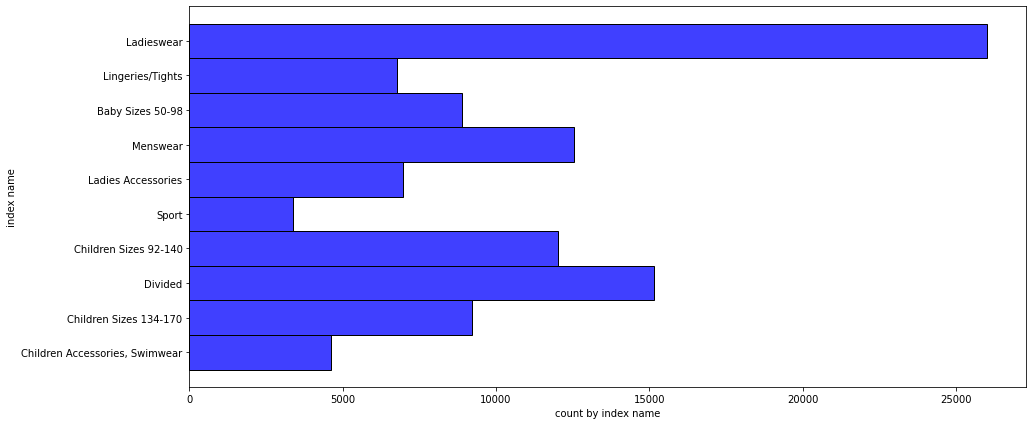

In [8]:

f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='index_name', color='blue')
ax.set_xlabel('count by index name')
ax.set_ylabel('index name')
plt.show()

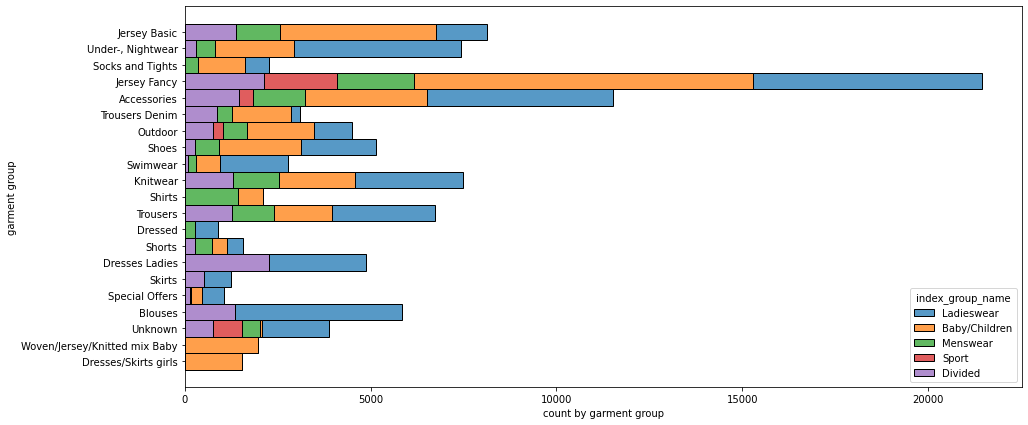

In [9]:
f, ax = plt.subplots(figsize=(15, 7))
ax = sns.histplot(data=article_df, y='garment_group_name', color='orange', hue='index_group_name', multiple="stack")
ax.set_xlabel('count by garment group')
ax.set_ylabel('garment group')
plt.show()

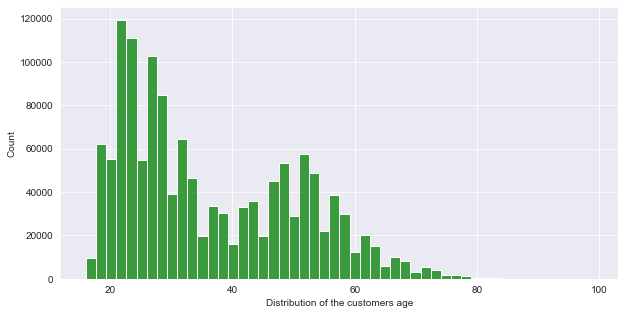

In [10]:
sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(10,5))
ax = sns.histplot(data=customer_df, x='age', bins=50, color='green')
ax.set_xlabel('Distribution of the customers age')
plt.show()

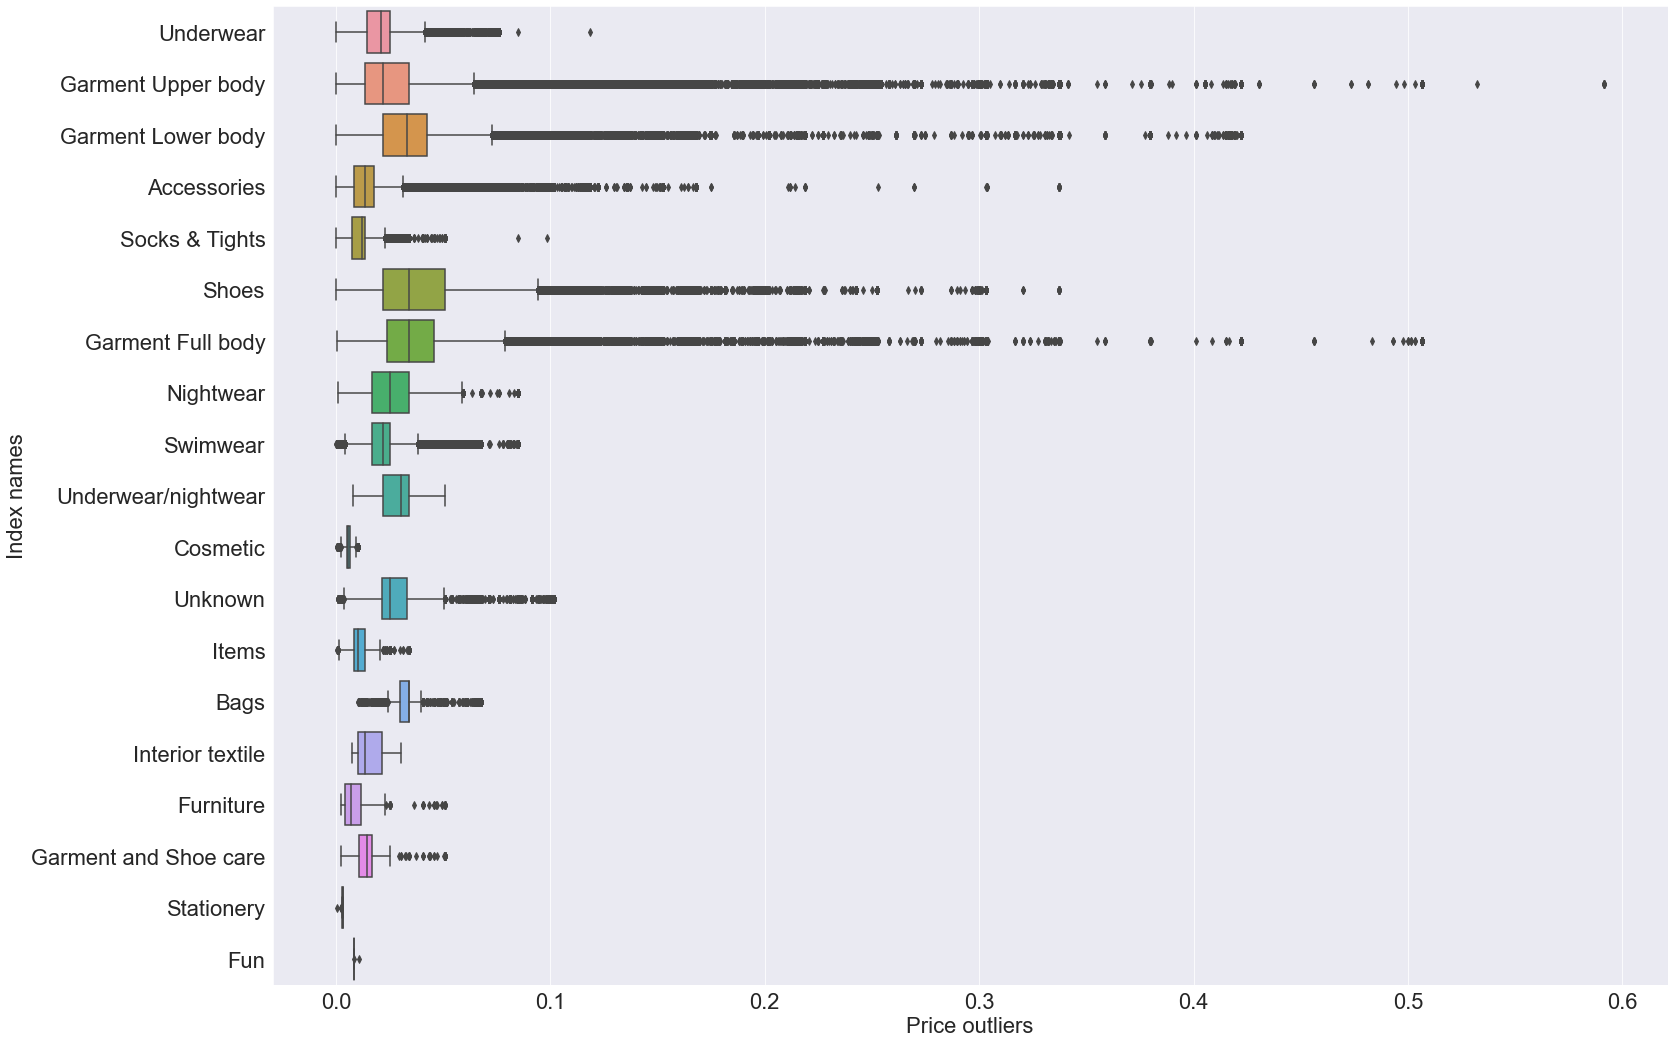

In [11]:
articles_for_merge = article_df[['article_id', 'prod_name', 'product_type_name', 'product_group_name', 'index_name']]
articles_for_merge = transaction_df[['customer_id', 'article_id', 'price', 't_dat']].merge(articles_for_merge, on='article_id', how='left')

sns.set_style("darkgrid")
f, ax = plt.subplots(figsize=(25,18))
ax = sns.boxplot(data=articles_for_merge, x='price', y='product_group_name')
ax.set_xlabel('Price outliers', fontsize=22)
ax.set_ylabel('Index names', fontsize=22)
ax.xaxis.set_tick_params(labelsize=22)
ax.yaxis.set_tick_params(labelsize=22)

plt.show()

# **Simple Feature Processing**

Having looked at some initial analysis, we next perform simple feature processing for customer and article dataframes.

In [12]:
def create_age_interval(x):
    if x <= 25:
        return [16, 25]
    elif x <= 35:
        return [26, 35]
    elif x <= 45:
        return [36, 45]
    elif x <= 55:
        return [46, 55]
    elif x <= 65:
        return [56, 65]
    else:
        return [66, 99]

customer_df["FN"].fillna(0, inplace=True)
customer_df["Active"].fillna(0, inplace=True)

# Set unknown the club member status & news frequency
customer_df["club_member_status"].fillna("UNKNOWN", inplace=True)

customer_df["fashion_news_frequency"] = customer_df["fashion_news_frequency"].replace({"None":"NONE"})
customer_df["fashion_news_frequency"].fillna("UNKNOWN", inplace=True)

# Set missing values in age with the median
customer_df["age"].fillna(customer_df["age"].median(), inplace=True)
customer_df["age_interval"] = customer_df["age"].apply(lambda x: create_age_interval(x))

customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[46, 55]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[16, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[16, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[46, 55]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[46, 55]"


In [13]:
# Replace missing values
article_df.fillna(value="No Description", inplace=True)

# Adjust the article ID and product code to be string & add "0"
#article_df["product_code"] = article_df["article_id"].apply(lambda x: x[:3])

#article_df.head()

In [14]:
article_df['article_id'] = article_df['article_id'].astype(str)
article_df['article_id'] = article_df['article_id'].apply(lambda x: x.zfill(10))

unique_customer_ids = customer_df.customer_id.unique()
unique_article_ids = article_df.article_id.unique()

article_ds = tf.data.Dataset.from_tensor_slices(dict(article_df[['article_id']]))
articles = article_ds.map(lambda x: x['article_id'])

Metal device set to: Apple M1 Pro


2022-08-07 15:34:56.260266: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-07 15:34:56.260409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We subselect 1 years worth of data to use for all the exercises this week.

In [15]:
train0 = train0[train0['t_dat'] <='2019-09-20']

# add 0 in article_id column (string)
train0['article_id'] = train0['article_id'].astype(str)
train0['article_id'] = train0['article_id'].apply(lambda x: x.zfill(10))
train0.head()

/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/ipykernel_56100/2214139367.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train0['article_id'] = train0['article_id'].astype(str)
/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/ipykernel_56100/2214139367.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train0['article_id'] = train0['article_id'].apply(lambda x: x.zfill(10))


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,0685687004,0.016932,2


Having selected this dataset, lets get to work. We will begin by describing the key metric we will use to evaluate the candidate generators, and then move on to discuss few candidate generator techniques. Finally, we will finish the project by comparing the recall metrics across the three candidate generators

# Key metric for candidate generation: _recall@k_

The goal of the candidate generator is to fetch enough reevant candidates for the ranker to rank. Indeed, the ranker works on top of the output of the candidate generator -- if the candidate generator fetches relevant candidates, the ranker can do a better job at ranking these candidates. However, if the candidate generator misses out on a large set of relevant items, the ranker cannot rank them since it doesn't have access to good candidate items.

Given such a role of the candidate generator, recall becomes the key metric with which we evaluate different candidate generators. Intuitively, *Recall* = of all relevant items, how many made it into the selected list?

_Recall@k_ is the proportion of relevant items found in the top-k selected candidates.

Mathematically recall@k is defined as follows:

_Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)_

Suppose we have a user who will make 5 purchases next month, and we wish to make 10 recommendations to this user on the homepage from among the set of 1 million products. Further suppose we have two candidate generators (CG-A and CG-B), each returning 100 candidates that the ranker can consumer and select the 10 recommendations. If CG-A is able to retrieve 3 of these 5 products amongst its set of 100 candidates, and CG-B is able to retrieve only 2 of the 5 products amongst its set of 100 candidates, then CG-A would have a higher recall than CG-B.
Recall for CG-A = 3/5
Recall for CG-B = 2/5


Lets implement this recall metric in a simple function and try it out.

In [16]:

def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))

# Recall@k = (# of recommended items @k that are relevant) / (total # of relevant items)
def estimateRecall(cg, purchase):
    return len(intersection(cg,purchase))/len(purchase)

In [17]:
purchases = ["item45","item97","item71","item125","item5"]
cg1 = ["item1","item97","item12","item105","item5","item17","item197","item122","item85","item15"]
cg2 = ["item13","item94","item14","item15","item5","item18","item197","item132","item86","item65"]
print("recall for cg1: ",estimateRecall(cg1,purchases))
print("recall for cg1: ",estimateRecall(cg2,purchases))

recall for cg1:  0.4
recall for cg1:  0.2


# **Traditional Candidate Generation**

With the metric in place, now lets look into a few obvious candiate generators.

> **1. Candidate Genertator 1: random products**
The simplest candidate generator to start with is a random candidate selector -- from amongst the list of products, randomly select few products.


> **2. Candidate Genertator 2: Top most popular products**
Another simple candidate selection strategy is to select the top-k most popular products from historic interactions and use this list as the set of candidates for the downstream ranking goal.


> **3. Candidate Genertator 3: Two-tower model CG**
One of most popular, and industry-wide used CGs is a two-tower neural network. This is a learnt deep model with one tower for the user and another tower for the product, followed by a dot product. We describe this model in detail further down the notebook.


Below we will implement each of these three candidate generators and compare their performace in terms of recall metric.

In order to have a clean evaluation set-up, we will divide the transactions data we have into train and test split. We look at one year's of purchases and use the first 9 months as training data and the remaining three months as the test data.

In [18]:
#train0 = pd.read_csv('hmdata/transactions_train.csv.zip')
train = train0[(train0['t_dat']<='2019-06-20') ]
#train = train0[(train0['t_dat']<='2019-06-20')]
test = train0[train0['t_dat'] >='2019-06-20']#[train0['t_dat'] <='2020-09-20']

In [19]:
train.t_dat.max(), train.t_dat.min(), train0.t_dat.max(), train0.t_dat.min()

('2019-06-20', '2018-09-20', '2019-09-20', '2018-09-20')

For ease of evaluation, without any loss of generalization, we only consider customers that have made a purchase in both train and test time-periods. The methods and set-up remain the same for all other customers as well.

In [20]:
c1 = train['customer_id'].to_list()
c2 = test['customer_id'].to_list()

commonUsers = intersection(c1, c2)

print(len(train),len(test),len(c1),len(c2),len(commonUsers))

12241294 4686893 12241294 4686893 423753


Here commonUsers represent the set of users for whom we would be interested in generating candidates.

In [21]:
#Candidate Generator 1: random products
    
def getKCandidatesRandom(u,k):
    return random.sample(train['article_id'].to_list(),k)

In [22]:
#Candidate Generator 2: top-k popular products based on historic interactions

def getTopKCandidatesPopular(u,k):
    c = Counter(train['article_id'].to_list())
    topPopular = [article for article, count in c.most_common(k)]
    return topPopular


In [117]:
# with the 2 CGs defined, we can now query these CGs for a set of users,
# and compute the recall metrics to see how well they perform.

def runCandidateGeneration(method,k):
    overallRecall = 0
    recallList = []
    i=0
    userSet = commonUsers[0:100]
    for u in tqdm(userSet):
        purchaseList = test[test['customer_id']==u]['article_id'].to_list()
        cg = method(u,k)
        r = estimateRecall(cg,purchaseList)
        overallRecall+=r
        recallList.append(r)
    overallRecall = overallRecall/len(userSet)
    return (overallRecall,recallList)

In [24]:
# Running metric calculations for the CG 1: random CG, to fetch 100 and 1000 candidates.
r, rlist = runCandidateGeneration(getKCandidatesRandom,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getKCandidatesRandom,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.0


  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.08796176046176045


In [25]:
# Running metric calculations for CG 2: top popular products CG, to fetch 100 and 1000 candidates.

r, rlist = runCandidateGeneration(getTopKCandidatesPopular,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getTopKCandidatesPopular,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.03186507936507936


  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.11292207792207794


We notice that the recall@k metric is significantly higher for popular CG than for random CG, which is as per our expectations.

Both these CGs are non-learnt, and generic across all users. We now switch to discuss a learnt CG model -- the two-tower model which we covered in the Monday lecture.

# Week1 Solutions
## Additional EDA to extract relevant features

## Attributes Exploration

In [26]:
customer_df.head()

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,age_interval
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0.0,0.0,ACTIVE,NONE,49.0,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...,"[46, 55]"
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0.0,0.0,ACTIVE,NONE,25.0,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...,"[16, 25]"
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0.0,0.0,ACTIVE,NONE,24.0,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...,"[16, 25]"
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0.0,0.0,ACTIVE,NONE,54.0,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...,"[46, 55]"
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.0,1.0,ACTIVE,Regularly,52.0,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...,"[46, 55]"


In [27]:
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [28]:
article_df.shape

(105542, 25)

In [29]:
article_df.nunique()/article_df.shape[0] * 100

article_id                      100.000000
product_code                     44.744272
prod_name                        43.466108
product_type_no                   0.125069
product_type_name                 0.124121
product_group_name                0.018002
graphical_appearance_no           0.028425
graphical_appearance_name         0.028425
colour_group_code                 0.047375
colour_group_name                 0.047375
perceived_colour_value_id         0.007580
perceived_colour_value_name       0.007580
perceived_colour_master_id        0.018950
perceived_colour_master_name      0.018950
department_no                     0.283300
department_name                   0.236873
index_code                        0.009475
index_name                        0.009475
index_group_no                    0.004737
index_group_name                  0.004737
section_no                        0.054007
section_name                      0.053059
garment_group_no                  0.019897
garment_gro

In [30]:
article_df.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43405
dtype: int64

In [31]:
article_df.garment_group_name.unique(), article_df.index_name.unique(), article_df.index_group_name.unique()

(array(['Jersey Basic', 'Under-, Nightwear', 'Socks and Tights',
        'Jersey Fancy', 'Accessories', 'Trousers Denim', 'Outdoor',
        'Shoes', 'Swimwear', 'Knitwear', 'Shirts', 'Trousers', 'Dressed',
        'Shorts', 'Dresses Ladies', 'Skirts', 'Special Offers', 'Blouses',
        'Unknown', 'Woven/Jersey/Knitted mix Baby', 'Dresses/Skirts girls'],
       dtype=object),
 array(['Ladieswear', 'Lingeries/Tights', 'Baby Sizes 50-98', 'Menswear',
        'Ladies Accessories', 'Sport', 'Children Sizes 92-140', 'Divided',
        'Children Sizes 134-170', 'Children Accessories, Swimwear'],
       dtype=object),
 array(['Ladieswear', 'Baby/Children', 'Menswear', 'Sport', 'Divided'],
       dtype=object))

In [32]:
article_df.graphical_appearance_name.unique()

array(['Solid', 'Stripe', 'All over pattern', 'Melange', 'Transparent',
       'Metallic', 'Application/3D', 'Denim', 'Colour blocking', 'Dot',
       'Other structure', 'Contrast', 'Treatment', 'Check', 'Chambray',
       'Front print', 'Glittering/Metallic', 'Mixed solid/pattern',
       'Placement print', 'Other pattern', 'Neps', 'Embroidery', 'Lace',
       'Jacquard', 'Unknown', 'Argyle', 'Slub', 'Mesh', 'Sequin',
       'Hologram'], dtype=object)

we'll assume that the following features represent the users preferences
- Graphical Appearance (Solid, Stripe, Glittering, .. etc) shape of product.
- Index Group Name (Ladieswear, Baby/Children .. etc) which gender is the user interested in.
- Garment Group Name (Denim, Socks and Tights, Shirts ..etc) type of product.

## How far should we look back
We'll explore here how long do we have transactions over a specific article

In [33]:
article_life = train0[['article_id','t_dat']].groupby('article_id', as_index=False).agg(['min','max'])

In [34]:
article_life.columns = ['min_dat','max_dat']
article_life = article_life.reset_index()
article_life.min_dat = pd.to_datetime(article_life.min_dat)
article_life.max_dat = pd.to_datetime(article_life.max_dat)


In [35]:
article_life['article_life'] = (article_life.max_dat - article_life.min_dat).dt.total_seconds()//60//60//24

Text(0, 0.5, '# of Articles')

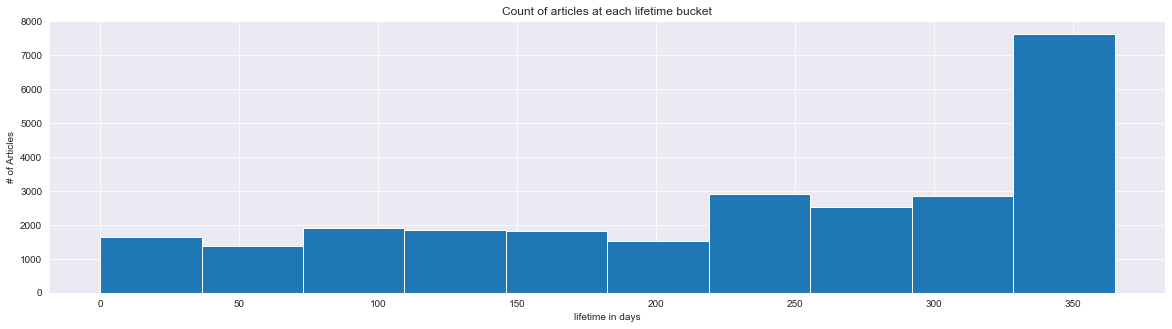

In [36]:
plt.figure(figsize=(20,5))
article_life.query('min_dat<="2018-10-01"')['article_life'].hist()
plt.title('Count of articles at each lifetime bucket')
plt.xlabel('lifetime in days')
plt.ylabel('# of Articles')

## the graph shows that some articles survives the whole year

As we can see here, most of the articles have been sold through out the year, so there's no a specific time frame to recommend from, an article sold a year ago can be recommended to a user now

## Task 1 Non Trained CGs

## Task 1.1 CG Based on Users Preferences

In [37]:
relevant_articles_cols = ['article_id','graphical_appearance_name', 'garment_group_name', 'index_group_name', 
                          'index_name', 'product_type_name']
if relevant_articles_cols[1] not in train.columns:
    train = train.merge(article_df[relevant_articles_cols], on='article_id')
    test = test.merge(article_df[relevant_articles_cols], on='article_id')


### Personalized User Articles

In [96]:
## calculated offline to speed up the function
c = Counter(train['article_id'].to_list())

def get_personalized_user_articles(u,k):
    
    
    user_items = train[train.customer_id == u]
    ## in future we should account for ratio of each category here
    graphical = user_items.graphical_appearance_name.unique()
    garment = user_items.garment_group_name.unique()
    index = user_items.index_group_name.unique()
    
    ## we'll be only exploiting user historical preferences
    user_pool = train[(train.graphical_appearance_name.isin(graphical)) & 
                      #(train.garment_group_name.isin(garment)) & 
                      ## seems garment made the predictions worse so i removed it
                      (train.index_group_name.isin(index))]
    ## we'll be only looking at most recent two months
    #user_pool = user_pool.query('t_dat > "2019-04-20"')
    
    c = Counter(user_pool['article_id'].to_list())
    user_pref_recomms = [article for article, count in c.most_common(int(k * 0.8))]
    
    
    ## we choose to pick 20% of the options out of the most popular items
    remaining_items = k - int(k*0.8)
    
    
    
    ## a article, c count
    ## getting popular items not included before .. 5 is just a proxy
    popular_items = [a for a, c in c.most_common(remaining_items * 5) 
                     if a not in user_pref_recomms][:remaining_items]

    
    user_pref_recomms  += popular_items
                                                              
    return user_pref_recomms

In [39]:
train

,t_dat,customer_id,article_id,price,sales_channel_id,graphical_appearance_name,garment_group_name,index_group_name,index_name,product_type_name
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0663713001,0.050831,2,Solid,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Underwear body
1,2018-09-20,3681748607f3287d2c3a65e00bb5fb153de30e9becf158...,0663713001,0.049475,2,Solid,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Underwear body
2,2018-09-20,4ef5967ff17bf474bffebe5b16bd54878e1d4105f7b4ed...,0663713001,0.050831,2,Solid,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Underwear body
3,2018-09-20,6b7b10d2d47516c82a6f97332478dab748070f09693f09...,0663713001,0.050831,1,Solid,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Underwear body
4,2018-09-20,8ac137752bbe914aa4ae6ad007a9a0c5b67a1ab2b2d474...,0663713001,0.050831,2,Solid,"Under-, Nightwear",Ladieswear,Lingeries/Tights,Underwear body
...,...,...,...,...,...,...,...,...,...,...
12241289,2019-06-20,ef5a2c3cf6244727a133956e4742cc94c93ae923bbe408...,0744703002,0.025407,1,Solid,Jersey Fancy,Ladieswear,Ladieswear,Top
12241290,2019-06-20,ef5a2c3cf6244727a133956e4742cc94c93ae923bbe408...,0744703002,0.025407,1,Solid,Jersey Fancy,Ladieswear,Ladieswear,Top
12241291,2019-06-20,f175fab5612700ed78d3ea4bc96f578bc97f64eb790384...,0754763001,0.033881,1,Solid,Accessories,Ladieswear,Ladies Accessories,Bag
12241292,2019-06-20,f767b2cdd1efeecbcef84b263178f42b203545a0cb2bc9...,0760020003,0.030492,2,Solid,Woven/Jersey/Knitted mix Baby,Baby/Children,Baby Sizes 50-98,Dress


In [40]:
# Running metric calculations for the CG 3: based on user interests
r, rlist = runCandidateGeneration(get_personalized_user_articles,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(get_personalized_user_articles,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.03186507936507936


  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.07387445887445887


## Task2. CG Based on Price Sensitivity

In [41]:
## let's try to create a price sensitity factor per user
article_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,0108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,0108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,0108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,0110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,0110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [42]:
print(article_df.columns)
print(article_df.garment_group_name.unique())

print(article_df.index_group_name.unique())

print(article_df.product_group_name.unique())


Index(['article_id', 'product_code', 'prod_name', 'product_type_no',
       'product_type_name', 'product_group_name', 'graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name',
       'perceived_colour_master_id', 'perceived_colour_master_name',
       'department_no', 'department_name', 'index_code', 'index_name',
       'index_group_no', 'index_group_name', 'section_no', 'section_name',
       'garment_group_no', 'garment_group_name', 'detail_desc'],
      dtype='object')
['Jersey Basic' 'Under-, Nightwear' 'Socks and Tights' 'Jersey Fancy'
 'Accessories' 'Trousers Denim' 'Outdoor' 'Shoes' 'Swimwear' 'Knitwear'
 'Shirts' 'Trousers' 'Dressed' 'Shorts' 'Dresses Ladies' 'Skirts'
 'Special Offers' 'Blouses' 'Unknown' 'Woven/Jersey/Knitted mix Baby'
 'Dresses/Skirts girls']
['Ladieswear' 'Baby/Children' 'Menswear' 'Sport' 'Divided']
['Garment Upper body' 'Underwear' 'Socks & T

In a best case scenario, we'll be experiment with each column to know which one can measure the user price sensitvity, for now we'll use the garment group name to decide the user price sensitivty

Text(0, 0.5, 'Garment Group Name')

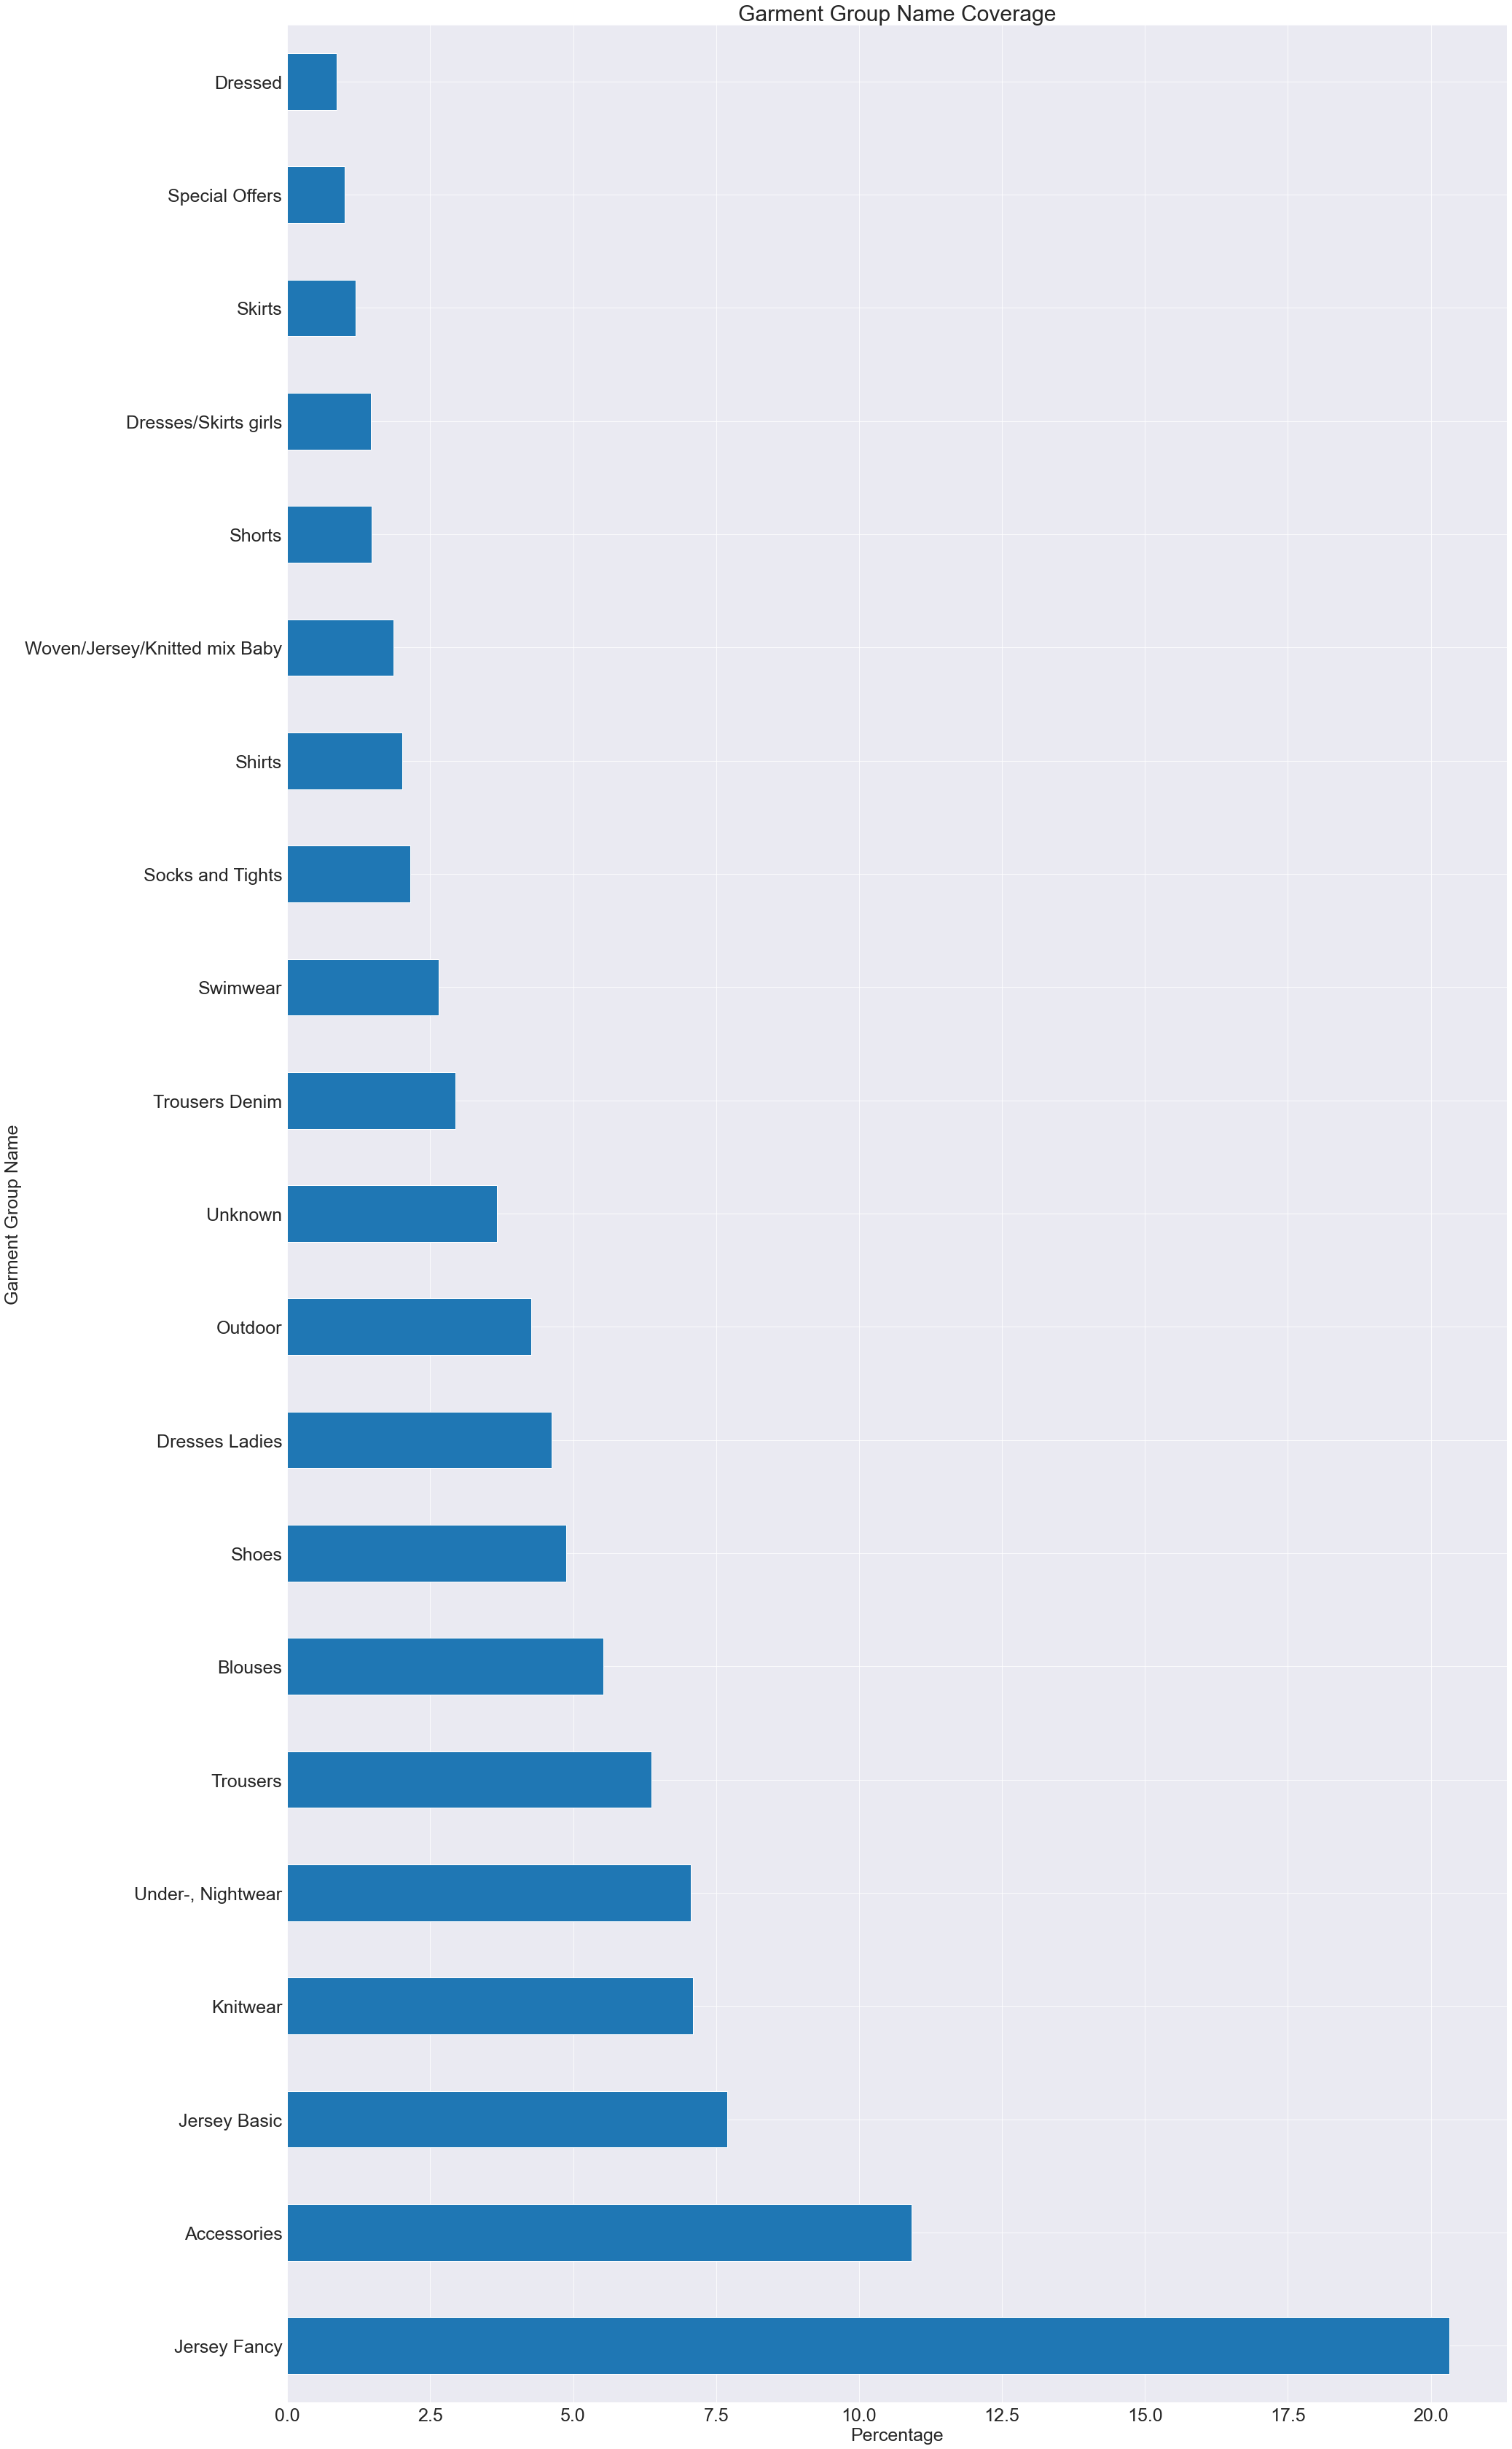

In [43]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 25})
plt.figure(figsize=(30,60))
(article_df.garment_group_name.value_counts(normalize=True) * 100).plot.barh()
plt.title('Garment Group Name Coverage')
plt.xlabel('Percentage')
plt.ylabel('Garment Group Name')

<AxesSubplot:xlabel='price', ylabel='garment_group_name'>

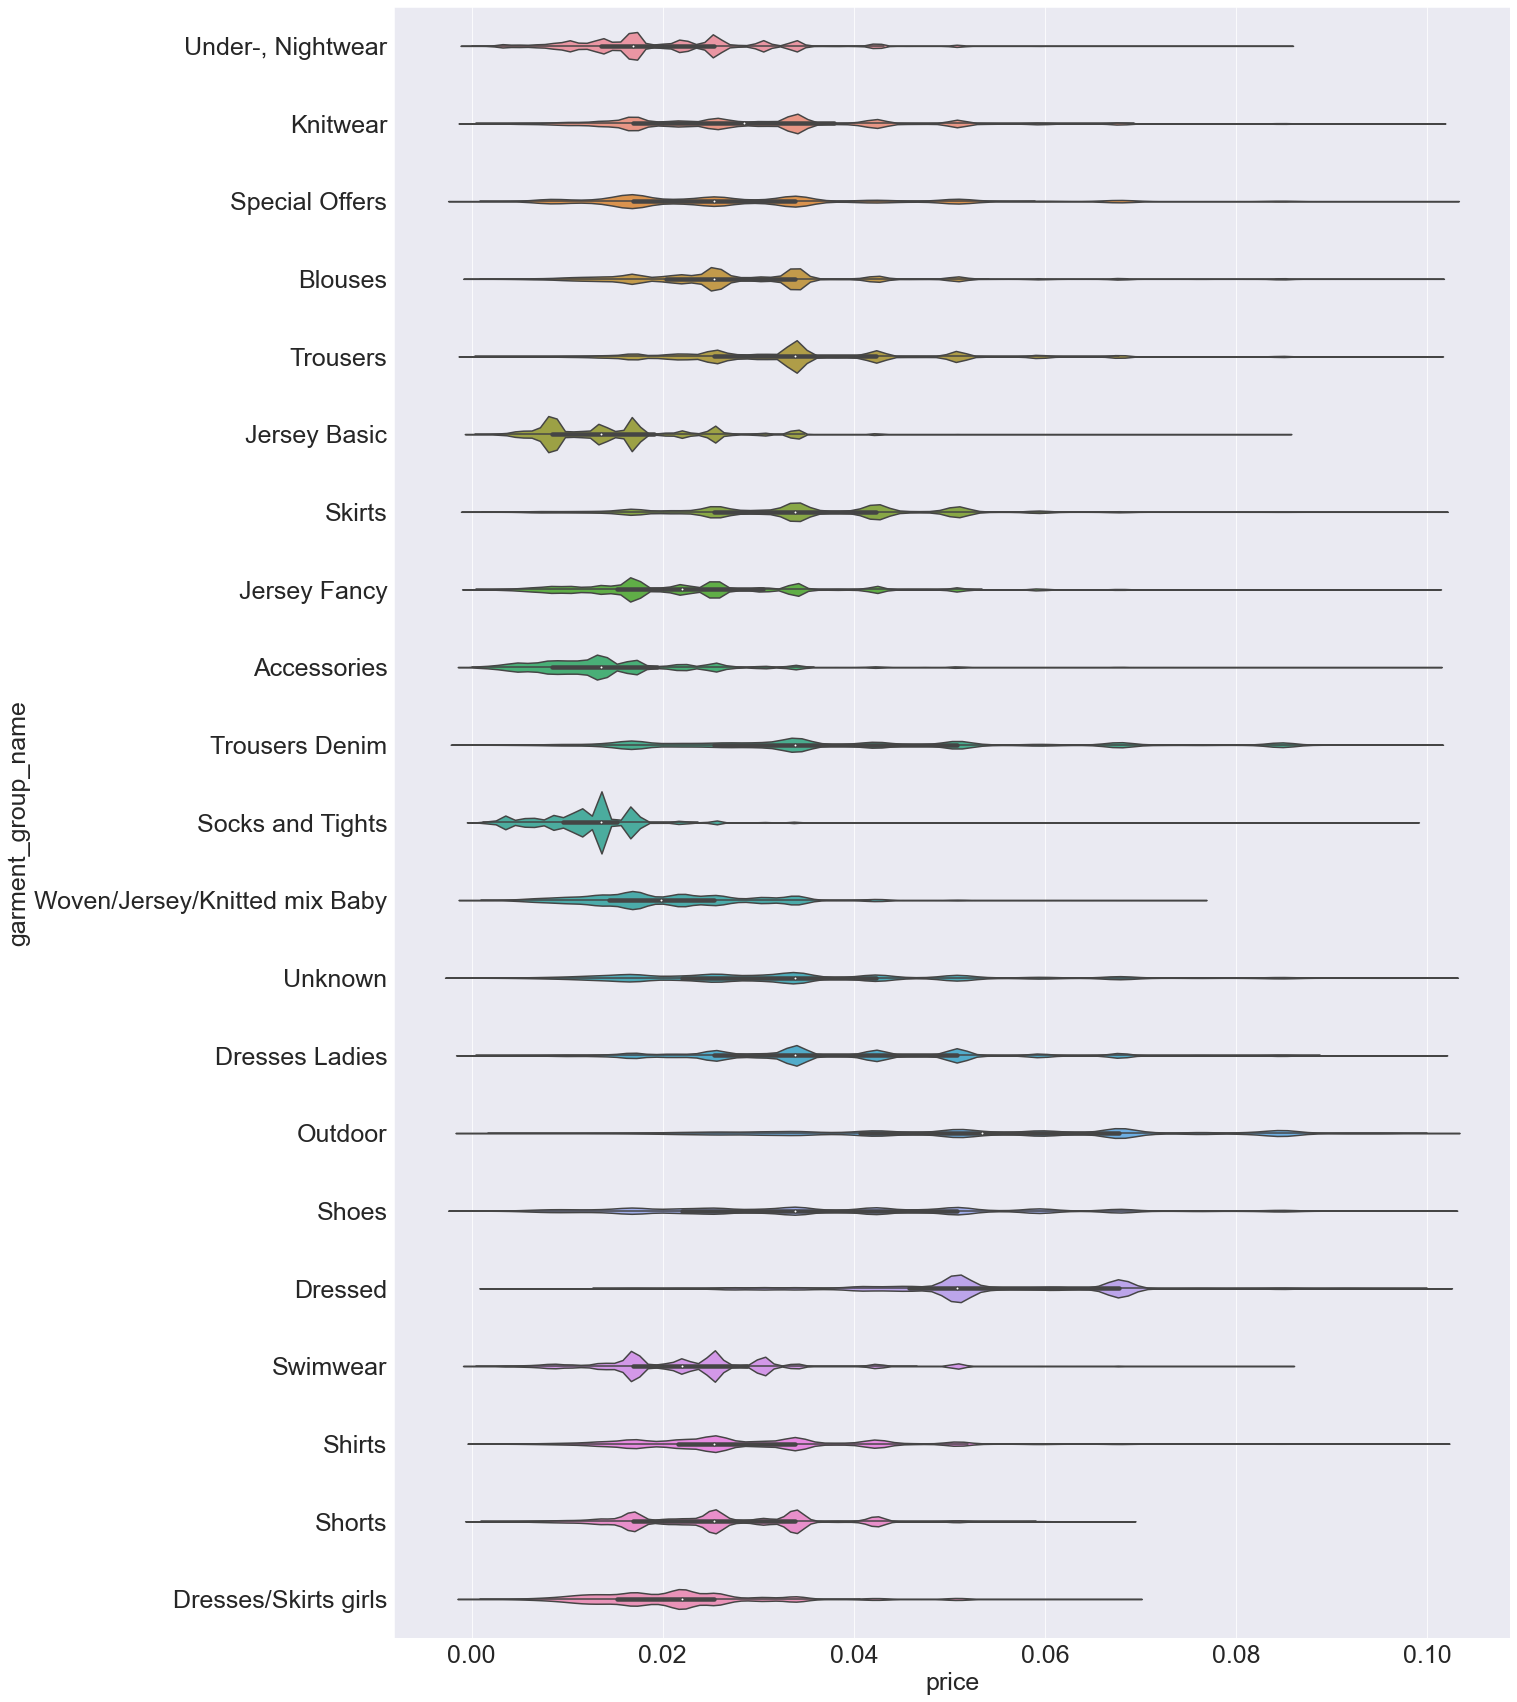

In [44]:
## After having a feeling of each group name, and that it should have representative pricing information
## let's see the price range
plt.figure(figsize=(20,30))
sns.violinplot(data = train.query('price<0.1'), x='price', y='garment_group_name')

<AxesSubplot:xlabel='price'>

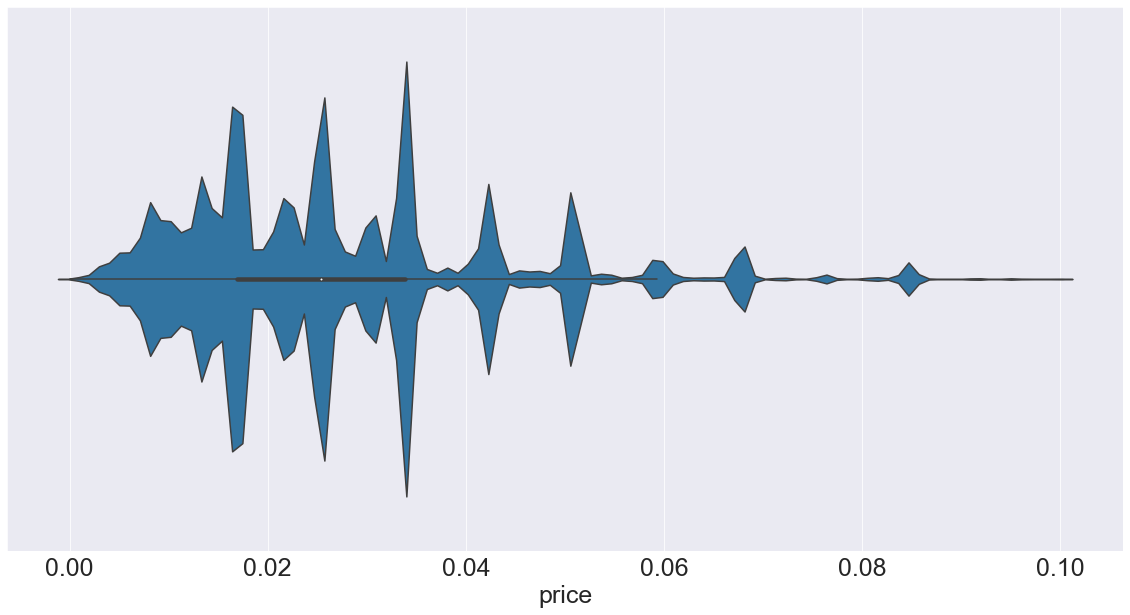

In [45]:
plt.figure(figsize=(20,10))
sns.violinplot(data = train.query('price<0.1'), x='price')

it seems that the price distribution isn't centered around a specific region, so I assume that the price sensitivity won't be effective, as there's obvious subdistributions within each garment group, so to compute it effectively, we'll need to compute it for each natural product category and calculate the user sensitivity per user-group pair, and generalize this sensitivity to user other groups that the user didn't buy in

/var/folders/md/3y3mq4_d7_z2mk6_2zh4lgxc0000gq/T/ipykernel_56100/2496563014.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_customers['cust'] = top_customers.customer_id.apply(lambda x: str(x)[:5])


<AxesSubplot:xlabel='price', ylabel='cust'>

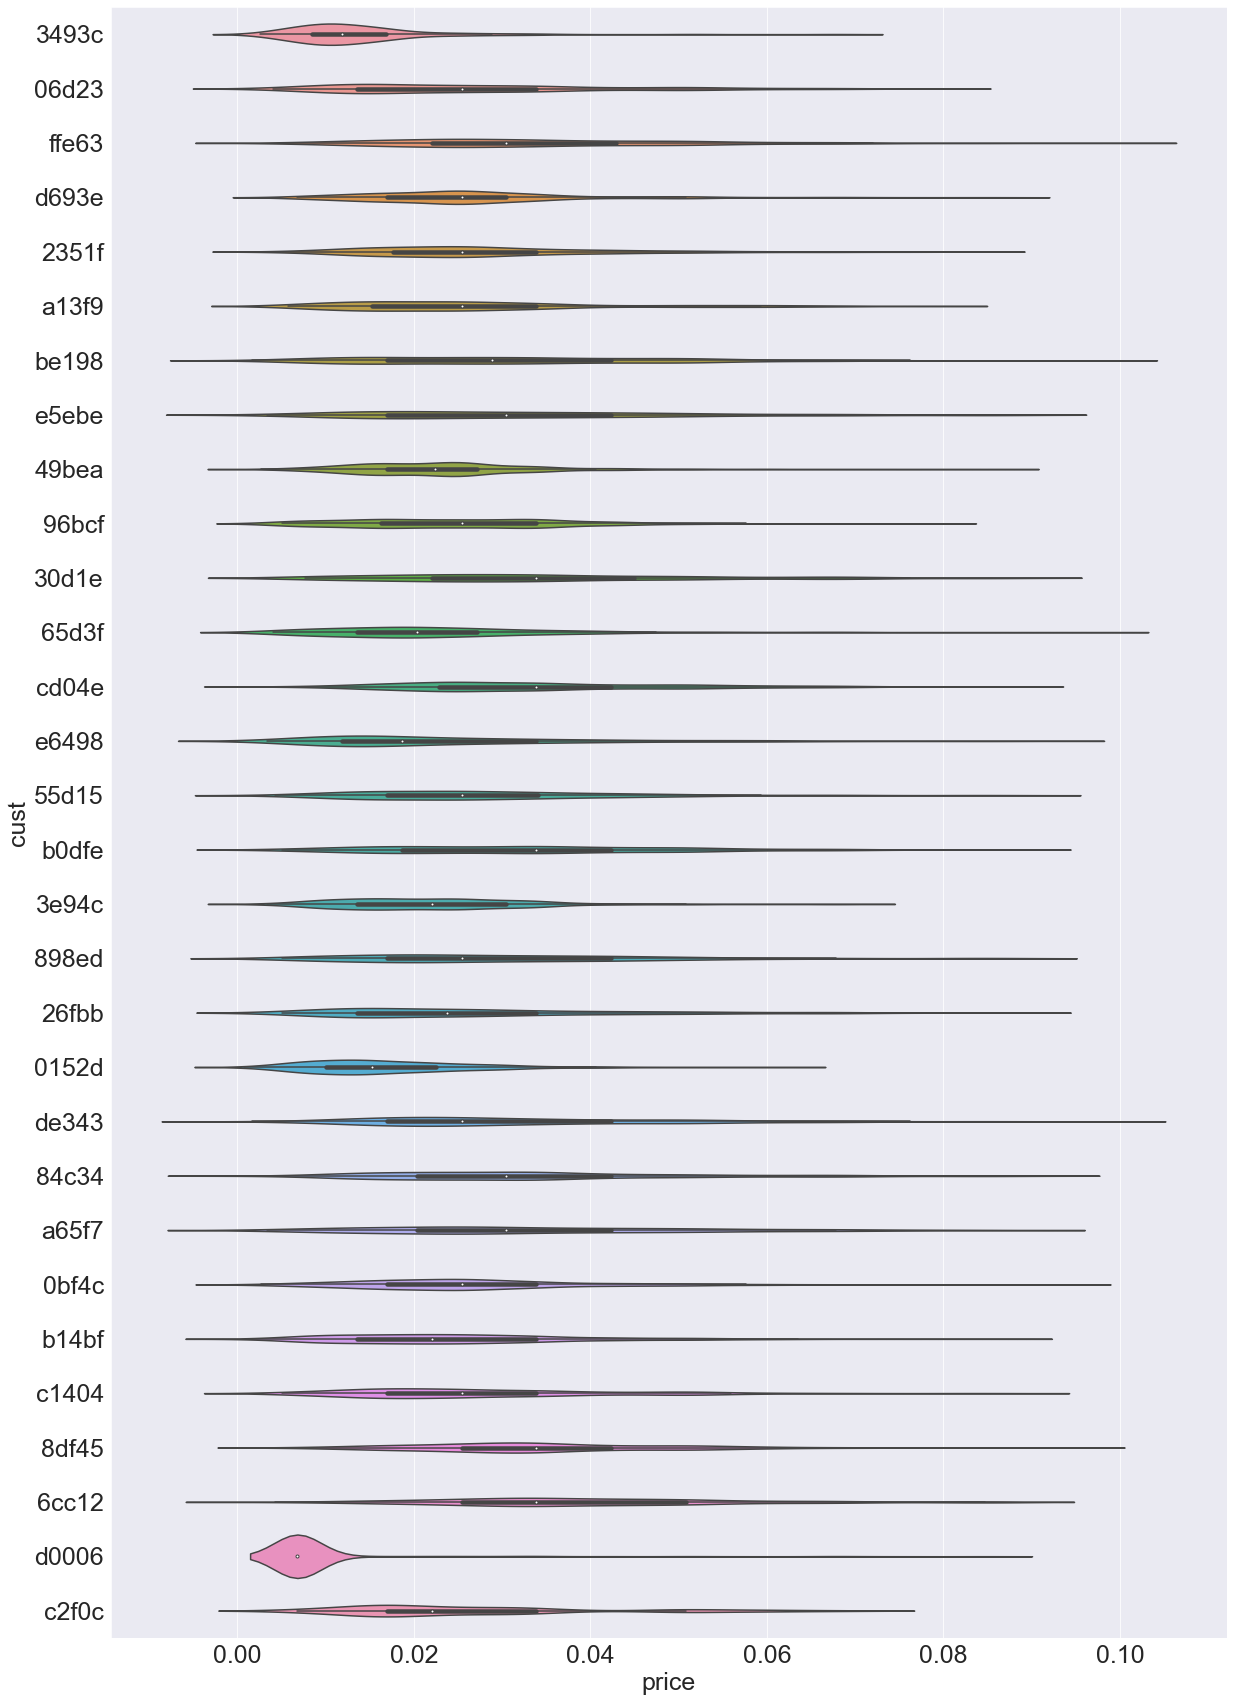

In [46]:
## we'll also have a look on the pricing distribution for users with the most purchases.

plt.figure(figsize=(20,30))
common_custs = train.customer_id.value_counts().index[:30]
top_customers = train[train.customer_id.isin(common_custs)]
top_customers['cust'] = top_customers.customer_id.apply(lambda x: str(x)[:5])
sns.violinplot(data = top_customers.query('price<0.1'), x='price', y='cust')

- it seems that for each customers the range of prices is distributed lower or higher than the average.
- so Calculating average might be suitable per customer
- Though the mean calculated here will be impacted by the category distribution, and user sensitivity should be calculated by comparing it to other users prices for the same category, as we can't say that a user got a cheap shoes for 50 Euro, and another on got a fancy shirt with 40Eur.
- In the ideal case, we should learn the std per customer and recommend items within a range of mean +- std

<AxesSubplot:>

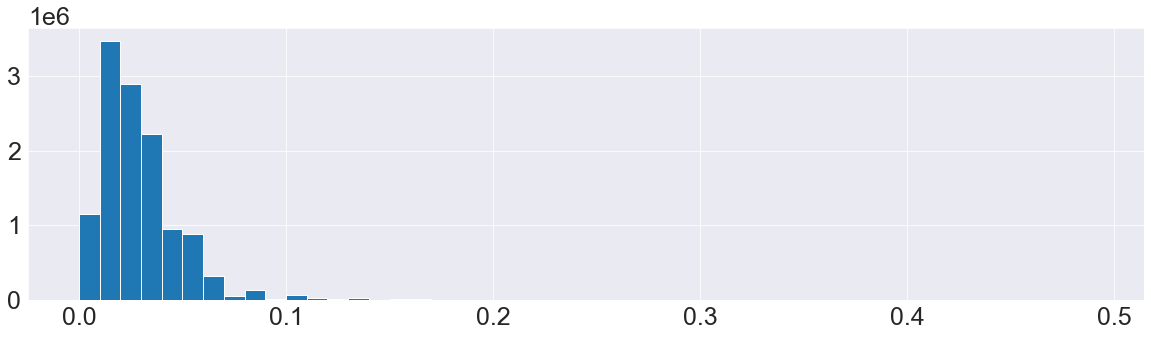

In [71]:
plt.figure(figsize=(20,5))

train.price.hist(bins=np.arange(0,0.5,0.01))

In [78]:
print('customers below 0.15 price', train.query('price<0.15').customer_id.nunique()/train.customer_id.nunique())

customers below 0.15 price 0.9988721926250331


In [79]:

## we'll remove any items with price > 0.1, and from a previous calculation 99% of the prices are below 0.1

## calculate mean price per category
user_avg_prices = train.query('price<0.15').groupby('customer_id', 
                                                    as_index=False)[['price']].agg({'price':['mean','std']})
user_avg_prices.columns = ['customer_id','price_avg','price_std']\

user_avg_prices.price_std.describe()
## as we can see some users bought only a single item, so. std is NAN, we'll replace these with avg of price_std

count    799436.000000
mean          0.012567
std           0.008074
min           0.000000
25%           0.007316
50%           0.011560
75%           0.016403
max           0.091684
Name: price_std, dtype: float64

In [86]:
user_avg_prices.price_avg.describe()

count    894533.000000
mean          0.028695
std           0.013198
min           0.000763
25%           0.020663
50%           0.026346
75%           0.033881
max           0.149339
Name: price_avg, dtype: float64

In [80]:
avg_std = user_avg_prices.price_std.mean()
user_avg_prices['price_std'].fillna(avg_std)
user_avg_prices['price_max'] = user_avg_prices['price_avg'] + user_avg_prices['price_std']
user_avg_prices['price_min'] = user_avg_prices['price_avg'] - user_avg_prices['price_std']
user_avg_prices.price_std.describe()

count    799436.000000
mean          0.012567
std           0.008074
min           0.000000
25%           0.007316
50%           0.011560
75%           0.016403
max           0.091684
Name: price_std, dtype: float64

In [82]:
## in test set we might find users not available in training set, so we'll calculate default avg price and std
unk_user_avg = train.query('price<0.15').price.mean()
unk_user_std = train.query('price<0.15').price.std()
unk_user_max = unk_user_avg + unk_user_std
unk_user_min = unk_user_avg - unk_user_std

In [95]:
## validate user_avg_prices has a single entry per user
user_avg_prices.customer_id.value_counts()

00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657    1
aa8823f101098d5d7aa23e33750e7aca6e9a3d66597fe0c5ac9db169cde788db    1
aa876b185d1da494cd6ffb6c64bebdb2319567690ed093a2860744725f6ce5ca    1
aa877d4a0ad36b6ff96580d6bdc645d429cd5445879e614ed39b4b4219c5032e    1
aa879fb0a5a01e586996e9ffd784a39cd2b308edb3a5b43421e98691794813b1    1
                                                                   ..
5569f5554b26924862ef1f6e2b90990adc9416e8c6ec34f5ac70d33012856a85    1
556a0be89ccece1417293391b989e4d36e064f9230c4efd74dfd91a736a96122    1
556a15c6b698f7e904a774e2e5b8cd759c658da28d6bb6fb186eefea3f55bb58    1
556a32844fd39582516df7cbd628ae692ebb6102ce1857e1ed03edcdf91caf28    1
ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1778d0116cffd259264    1
Name: customer_id, Length: 894533, dtype: int64

In [94]:
d = user_avg_prices.query('customer_id == "00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657"').iloc[0].to_dict()
x

{'customer_id': '00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657',
 'price_avg': 0.0369887005649717,
 'price_std': 0.01547548279842955,
 'price_max': 0.05246418336340125,
 'price_min': 0.02151321776654215}

### Personalized Pricing sensitive recommendations

In [97]:

c = Counter(train['article_id'].to_list())
def get_price_sensitive_user_articles(u,k):
    
    
    
    ## retreiving user price sensitivity
    user_price = user_avg_prices.query(f'customer_id == "{u}"').iloc[0]
    max_price = user_price['price_max']
    min_price = user_price['price_min']
    
    ## we'll be only looking at most recent two months
    #user_pool = user_pool.query('t_dat > "2019-04-20"')
    if u in train.customer_id.unique():
        user_pool = train[(train.price<=max_price) & (train.price>=min_price)]
    else:
        user_pool = train[(train.price<=unk_user_max) & (train.price>=unk_user_min)]
    
    
    ## we'll select 80% of the popular items within the price range and 20% of the popular items
    c = Counter(user_pool['article_id'].to_list())
    user_pref_recomms = [article for article, count in c.most_common(int(k * 0.8))]
    
    
    ## we choose to pick 20% of the options out of the most popular items
    remaining_items = k - int(k*0.8)
    
    
    ## getting popular items not included before .. 5 is just a proxy
    popular_items = [a for a, c in c.most_common(remaining_items * 5) 
                     if a not in user_pref_recomms][:remaining_items]
    
    user_pref_recomms  += popular_items
                                                              
    return user_pref_recomms

In [98]:
# Running metric calculations for the CG 3: based on user interests
r, rlist = runCandidateGeneration(get_price_sensitive_user_articles,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(get_price_sensitive_user_articles,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.005277777777777778


  0%|          | 0/10 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.06966810966810966


# **Two Tower Model: Candidate Generator**

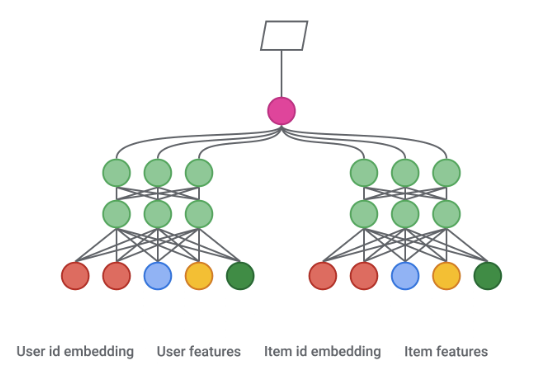

A two tower model is a neural network that is made up of two separate sub-models, one that learns representations for the users, and one that learns representations for candidate objects. This information is then combined in a single layer to produce a prediction of whether a user will like an item. This is currently one of the best-performing models for candidate generation, as it learns information from both the user and the items. Above, you can see a  visualization of how this process works.

This approach is useful for candidate generation across a wide variety of industries, from online retail to social media! With one tower representing the users and the other representing the items, the system can learn a lot about whether a user might like a particular item. These models are trained using implicit signals – YouTube, for example, might consider how many seconds a user streamed a video, or how they interacted with it. The learned information can then be combined to produce the final prediction.

In [99]:
embedding_dimension = 64

customer_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_customer_ids, mask_token=None),  
  tf.keras.layers.Embedding(len(unique_customer_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(64, activation='relu')
])


In [100]:
article_model = tf.keras.Sequential([
  tf.keras.layers.StringLookup(
      vocabulary=unique_article_ids, mask_token=None),
  tf.keras.layers.Embedding(len(unique_article_ids) + 1, embedding_dimension),
  tf.keras.layers.Dense(64, activation='relu')
])

### **Metric: FactorizedTopK**
To figure out how good our model is, we need to compare the affinity score that the model calculates for this pair to the scores of all the other possible candidates: if the score for the positive pair is higher than for all other candidates, our model is highly accurate.

To do this, we can use the tfrs.metrics.FactorizedTopK metric. The metric has one required argument: the dataset of candidates that are used as implicit negatives for evaluation.

 The default metric is top K categorical accuracy: how often the true candidate is in the top K candidates for a given query.

In [105]:
class HandMModel(tfrs.Model):
    
    def __init__(self, customer_model, article_model):
        super().__init__()
        self.article_model: tf.keras.Model = article_model
        self.customer_model: tf.keras.Model = customer_model
        self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=articles.batch(128).map(self.article_model)),
        )        

    def compute_loss(self, features: Dict[str, tf.Tensor], training=False) -> tf.Tensor:
    
        customer_embeddings = self.customer_model(features["customer_id"])    
        article_embeddings = self.article_model(features["article_id"])

        # The task computes the loss and the metrics.
        return self.task(customer_embeddings, article_embeddings,compute_metrics=not training)

TFRS exposes a base model class (tfrs.models.Model) which streamlines bulding models: all we need to do is to set up the components in the __init__ method, and implement the compute_loss method, taking in the raw features and returning a loss value.

The base model will then take care of creating the appropriate training loop to fit our model.


The tfrs.Model base class is a simply convenience class: it allows us to compute both training and test losses using the same method.

Under the hood, it's still a plain Keras model. You could achieve the same functionality by inheriting from tf.keras.Model and overriding the train_step and test_step functions (see the guide for details):

In [106]:
class NoBaseClassHandMModel(tf.keras.Model):
    
    def __init__(self, user_model, movie_model):
        super().__init__()
        self.movie_model: tf.keras.Model = movie_model
        self.user_model: tf.keras.Model = user_model
        self.task: tf.keras.layers.Layer = task
            
    def train_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Set up a gradient tape to record gradients.
        with tf.GradientTape() as tape:

          # Loss computation.
          customer_embeddings = self.customer_model(features["customer_id"])
          positive_article_embeddings = self.article_model(features["article_id"])
          loss = self.task(customer_embeddings, positive_article_embeddings)

          # Handle regularization losses as well.
          regularization_loss = sum(self.losses)

          total_loss = loss + regularization_loss

        gradients = tape.gradient(total_loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics
    
    def test_step(self, features: Dict[Text, tf.Tensor]) -> tf.Tensor:

        # Loss computation.
        customer_embeddings = self.customer_model(features["user_id"])
        positive_article_embeddings = self.article_model(features["movie_title"])
        loss = self.task(customer_embeddings, positive_article_embeddings)

        # Handle regularization losses as well.
        regularization_loss = sum(self.losses)

        total_loss = loss + regularization_loss

        metrics = {metric.name: metric.result() for metric in self.metrics}
        metrics["loss"] = loss
        metrics["regularization_loss"] = regularization_loss
        metrics["total_loss"] = total_loss

        return metrics

After defining the model, we can use standard Keras fitting and evaluation routines to fit and evaluate the model.

Let's first instantiate the model.

In [107]:
model = HandMModel(customer_model, article_model)
model.compile(optimizer=tf.keras.optimizers.Adam())

Then lets shuffle, batch, and cache the training and evaluation data, and train the model on the training data.


In [108]:


train_ds = tf.data.Dataset.from_tensor_slices(dict(train[['customer_id','article_id']])).shuffle(100_000).batch(8192).cache()
test_ds = tf.data.Dataset.from_tensor_slices(dict(test[['customer_id','article_id']])).batch(4096).cache()
    
num_epochs = 50

history = model.fit(train_ds,epochs=num_epochs, verbose=1)

Epoch 1/4


2022-08-07 16:30:24.266616: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-07 16:30:24.271137: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1495/1495 [==============================] - 272s 181ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 72434.8230 - regularization_loss: 0.0000e+00 - total_loss: 72434.8230
Epoch 2/4
1495/1495 [==============================] - 455s 305ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 68546.6868 - regularization_loss: 0.0000e+00 - total_loss: 68546.6868
Epoch 3/4
1495/1495 [==============================] - 260s 174ms/step - factorized_top_k/top_1_categorical_accuracy: 0.0000

As the model trains, the loss is falling and a set of top-k retrieval metrics is updated. These tell us whether the true positive is in the top-k retrieved items from the entire candidate set. For example, a top-5 categorical accuracy metric of 0.2 would tell us that, on average, the true positive is in the top 5 retrieved items 20% of the time.

Finally, we can evaluate our model on the test set:

In [109]:
test

,t_dat,customer_id,article_id,price,sales_channel_id,graphical_appearance_name,garment_group_name,index_group_name,index_name,product_type_name
0,2019-06-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0760695003,0.049746,2,Denim,Trousers,Ladieswear,Ladieswear,Shorts
1,2019-06-20,0001d44dbe7f6c4b35200abdb052c77a87596fe1bdcc37...,0760695003,0.049746,2,Denim,Trousers,Ladieswear,Ladieswear,Shorts
2,2019-06-20,00465ec96dd32dca19f85108cbce142de6667a7ace8208...,0760695003,0.050831,2,Denim,Trousers,Ladieswear,Ladieswear,Shorts
3,2019-06-20,3baf75059480a4e0885fecd6accbc4da1a0b240bfc2cb4...,0760695003,0.050831,2,Denim,Trousers,Ladieswear,Ladieswear,Shorts
4,2019-06-20,8f59c9877b4eda93f289989173685911ce40e4d84fc32d...,0760695003,0.038136,2,Denim,Trousers,Ladieswear,Ladieswear,Shorts
...,...,...,...,...,...,...,...,...,...,...
4686888,2019-09-20,f638ea68481aef30bedf4aa227084bd697c1009fd8258a...,0739986003,0.013542,1,Solid,Accessories,Baby/Children,"Children Accessories, Swimwear",Scarf
4686889,2019-09-20,fbe7438e02683544254025cdbf946f0a00e72d8cd413c6...,0662935002,0.035576,1,Melange,Knitwear,Ladieswear,Ladieswear,Sweater
4686890,2019-09-20,fc3a19970581faa9a38f480eed46bffd55367669f9f95c...,0774177005,0.033881,2,Placement print,Jersey Fancy,Baby/Children,Children Sizes 134-170,Sweater
4686891,2019-09-20,fe567c91d796bb8cf2f075377b174d6a831bcebef801ee...,0804472003,0.030492,2,Solid,Shoes,Baby/Children,"Children Accessories, Swimwear",Sneakers


In [110]:
test_ds = tf.data.Dataset.from_tensor_slices(dict(test.sample(2000)[['customer_id','article_id']])).batch(500).cache()
model.evaluate(test_ds, return_dict=True)


2022-08-07 16:55:04.803429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:04.912231: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:04.922142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/4 [======>.......................] - ETA: 17s - factorized_top_k/top_1_categorical_accuracy: 0.0020 - factorized_top_k/top_5_categorical_accuracy: 0.0040 - factorized_top_k/top_10_categorical_accuracy: 0.0040 - factorized_top_k/top_50_categorical_accuracy: 0.9380 - factorized_top_k/top_100_categorical_accuracy: 0.9760 - loss: 3626.6033 - regularization_loss: 0.0000e+00 - total_loss: 3626.6033

2022-08-07 16:55:09.994522: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:10.004452: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2/4 [==============>...............] - ETA: 10s - factorized_top_k/top_1_categorical_accuracy: 0.0010 - factorized_top_k/top_5_categorical_accuracy: 0.0020 - factorized_top_k/top_10_categorical_accuracy: 0.0020 - factorized_top_k/top_50_categorical_accuracy: 0.9360 - factorized_top_k/top_100_categorical_accuracy: 0.9780 - loss: 3637.7435 - regularization_loss: 0.0000e+00 - total_loss: 3637.7435

2022-08-07 16:55:15.008719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:15.018744: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/4 [=====================>........] - ETA: 4s - factorized_top_k/top_1_categorical_accuracy: 6.6667e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0020 - factorized_top_k/top_10_categorical_accuracy: 0.0020 - factorized_top_k/top_50_categorical_accuracy: 0.9373 - factorized_top_k/top_100_categorical_accuracy: 0.9793 - loss: 3610.8999 - regularization_loss: 0.0000e+00 - total_loss: 3610.8999

2022-08-07 16:55:19.327408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:19.336013: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


4/4 [==============================] - 21s 5s/step - factorized_top_k/top_1_categorical_accuracy: 5.0000e-04 - factorized_top_k/top_5_categorical_accuracy: 0.0015 - factorized_top_k/top_10_categorical_accuracy: 0.0015 - factorized_top_k/top_50_categorical_accuracy: 0.9365 - factorized_top_k/top_100_categorical_accuracy: 0.9790 - loss: 3539.7708 - regularization_loss: 0.0000e+00 - total_loss: 3539.7708


{'factorized_top_k/top_1_categorical_accuracy': 0.0005000000237487257,
 'factorized_top_k/top_5_categorical_accuracy': 0.001500000013038516,
 'factorized_top_k/top_10_categorical_accuracy': 0.001500000013038516,
 'factorized_top_k/top_50_categorical_accuracy': 0.936500072479248,
 'factorized_top_k/top_100_categorical_accuracy': 0.9790000319480896,
 'loss': 3433.0771484375,
 'regularization_loss': 0,
 'total_loss': 3433.0771484375}

### **Making predictions**
Now that we have a model, we would like to be able to make predictions. We can use the tfrs.layers.factorized_top_k.BruteForce layer to do this.

In [113]:
tf.__version__, tfrs.__version__

('2.9.0', 'v0.7.0')

In [114]:
articles = article_ds.map(lambda x: x['article_id'])

# Create a model that takes in raw customer features, and
index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model,k=50)
# recommends articles out of the entire dataset.
index.index_from_dataset(
  tf.data.Dataset.zip((articles.batch(1000), articles.batch(1000).map(model.article_model)))
)

# Get recommendations.
_, titles = index(tf.constant(["00000dbacae5abe5e23885899a1fa44253a17956c6d1c3d25f88aa139fdfc657"]))
print(f"Recommendations for customer: {titles[0, :100]}")

2022-08-07 16:55:34.625871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Recommendations for customer: [b'0717583001' b'0554541016' b'0518648001' b'0726128002' b'0680369001'
 b'0720629001' b'0744817003' b'0718936002' b'0717475001' b'0733700001'
 b'0532102012' b'0554541020' b'0278038036' b'0749247001' b'0738013001'
 b'0736633001' b'0108775015' b'0108775015' b'0108775015' b'0108775015'
 b'0108775015' b'0108775015' b'0108775015' b'0108775015' b'0108775015'
 b'0108775015' b'0108775015' b'0108775015' b'0108775015' b'0108775015'
 b'0108775015' b'0108775015' b'0108775015' b'0108775015' b'0108775015'
 b'0108775015' b'0108775015' b'0108775015' b'0108775015' b'0108775015'
 b'0108775015' b'0108775015' b'0108775015' b'0108775015' b'0108775015'
 b'0108775015' b'0108775015' b'0108775015' b'0108775015' b'0108775015']


Now that we have the ability to make predictions, we would like to use this model and fetch the top-k candidates for the set of customers we have used for the previous two candidate generators.

Similar to the CG1 and CG2 functions, we define the two-tower CG function that takes in a customer ID and value k, and returns the list of top-k products as the list of candidate products.

In [115]:
def getTopKCandidates2Tower(u,k):
    # Create a model that takes in raw customer features, and
    index = tfrs.layers.factorized_top_k.BruteForce(model.customer_model,k)
    # recommends articles out of the entire dataset.
    index.index_from_dataset(
        tf.data.Dataset.zip((articles.batch(1000), articles.batch(1000).map(model.article_model)))
    )
    _, candidates = index(tf.constant([u]))
    candidates = candidates.numpy().tolist()[0]
    cg = []
    for c in candidates:
        cg.append(c.decode("utf-8") )
    return (cg)

We can now use this function to estimate the recall metrics for this new CG, and compare with the other 2 CGs we implemented before.

  0%|          | 0/10 [00:00<?, ?it/s]

2022-08-07 16:55:39.282827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:40.098966: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:40.867112: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:41.692823: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:42.459625: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:43.234301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:44.068104: I tensorflow/core/grappler/optimizers/cust

recall for candidate generation at k=100 candidates fetched:  0.0


  0%|          | 0/10 [00:00<?, ?it/s]

2022-08-07 16:55:47.172455: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:47.939984: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:48.711835: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:49.490254: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:50.258588: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:51.033404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 16:55:51.813058: I tensorflow/core/grappler/optimizers/cust

recall for candidate generation at k=1000 candidates fetched:  0.03708874458874459


## Comparing all 4 CGs We've developed so far

In [122]:
# Running metric calculations for the CG 1: random CG, to fetch 100 and 1000 candidates.
r, rlist = runCandidateGeneration(getKCandidatesRandom,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getKCandidatesRandom,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.0035785048285048287


  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.04225593493318825


In [118]:
# Running metric calculations for CG 2: top popular products CG, to fetch 100 and 1000 candidates.

r, rlist = runCandidateGeneration(getTopKCandidatesPopular,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(getTopKCandidatesPopular,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.021358287545787544


  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.09991650863368129


In [119]:
# Running metric calculations for the CG 3: based on user personalized interests
r, rlist = runCandidateGeneration(get_personalized_user_articles,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(get_personalized_user_articles,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.019470009157509155


  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.10469214965932232


In [120]:
# Running metric calculations for the CG 4: based on user price sensitivity interests
r, rlist = runCandidateGeneration(get_price_sensitive_user_articles,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)

r, rlist = runCandidateGeneration(get_price_sensitive_user_articles,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=100 candidates fetched:  0.016756105006105002


  0%|          | 0/100 [00:00<?, ?it/s]

recall for candidate generation at k=1000 candidates fetched:  0.0845142746142746


In [121]:
# Running metric calculations for the CG 5: based on two tower model
r, rlist = runCandidateGeneration(getTopKCandidates2Tower,k=100)
print("recall for candidate generation at k=100 candidates fetched: ", r)
r, rlist = runCandidateGeneration(getTopKCandidates2Tower,k=1000)
print("recall for candidate generation at k=1000 candidates fetched: ", r)

  0%|          | 0/100 [00:00<?, ?it/s]

2022-08-07 18:22:24.106255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:22:25.238342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:22:26.044597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:22:26.840328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:22:27.639838: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:22:28.455807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:22:29.243509: I tensorflow/core/grappler/optimizers/cust

2022-08-07 18:23:06.869061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:07.689808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:08.498813: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:09.309965: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:10.121134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:10.991094: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:11.809993: I tensorflow/core/grappler/optimizers/cust

recall for candidate generation at k=100 candidates fetched:  0.0


  0%|          | 0/100 [00:00<?, ?it/s]

2022-08-07 18:23:44.495057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:45.281105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:46.106722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:46.943098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:47.750033: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:48.563728: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:23:49.414308: I tensorflow/core/grappler/optimizers/cust

2022-08-07 18:24:26.428961: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:24:27.213953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:24:27.994651: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:24:28.775620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:24:29.552886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:24:30.334718: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-07 18:24:31.114006: I tensorflow/core/grappler/optimizers/cust

recall for candidate generation at k=1000 candidates fetched:  0.029571114996115


Now lets compile the results from the three different Candidate Generators we implemented:

**Recall at 100**
- CG1:Random 0.0
- CG2:Popular 0.0203
- CG3: Two-tower 0.0013

**Recall at 1000**
- CG1:Random 0.057
- CG2:Popular 0.0678
- CG3: Two-tower 0.15

We notice that the random CG performs the worst, and with just 4 epochs of training, the two-tower CG is able to give a significant improvement in recall metric for k=1000 candidates.

This completes the week 1 project, where we looked at the basic implementation of the two-tower model for candidate generator. The retrieved set of candidates from the CG output forms the dataset on which sophiticated rankers operate. Due to low-latency requirements, high-capacity rankers do not operate on top of the large candidate pool of millions of items, so CGs help them by sub-selecting a smaller set of candidates for the ranker to operate upon.  In week 2 we will implement a few ranking methods that will work directly on top of the candidates that these CG generate.

Important to note – the embeddings from the pen-ultimate layer of these models are typically stored for real-time retrieval. Indeed, these embeddings represent the user and items in a shared embedding space and can be consumed by various models powering downstream tasks. To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. In week 3 project, we will briefly try a few such approximate NN approaches when dealing with user representations.

**Goal for this week:**
Implement two personalized non-learnt candidate generators:

1.   CG personalized to user’s interest
2.   Personalized to user’s price sensitivity

Once implemented, compare and report recall-k metrics together with the results of the 2 non-personalized CG and two-tower model. Please use k=100, and k=1000 to report the metrics.

**[optional] Adding features to two-tower model**
The two-tower we implemented just uses the customer-ID and article-ID as features. It'd be good to add additional features about customer and articles as input features and see how the recall@k performance changes.

